# Install and Load Libraries/Data

In [17]:
#!pip install skorch

In [18]:
import random
import torch # type: ignore
import numpy as np  # type: ignore
import pandas as pd # type: ignore
from torch import nn # type: ignore
from skorch import NeuralNetClassifier # type: ignore
from sklearn.pipeline import Pipeline # type: ignore
from sklearn.compose import ColumnTransformer # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV # type: ignore
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer # type: ignore
from sklearn.impute import SimpleImputer # type: ignore
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

# Set the seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [19]:
# Paths to data folders
#train_csv_path = './data/merged_train.csv'
#test_csv_path = './data/merged_test.csv'

train_csv_path = './data/processed_train_df.csv'
test_csv_path = './data/processed_test_df.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [20]:
train_df.shape

(3960, 115)

# Data Splitting and Scaling

In [21]:
# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

In [22]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [23]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

In [24]:
# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())  # Scale features
])

# Define preprocessing for categorical data
#categorical_pipeline = Pipeline(steps=[
    #('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot Encode
#])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols)#,
    #('cat', categorical_pipeline, categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [25]:
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer (without activation function)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

In [26]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights)

In [27]:
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer_skorch = make_scorer(qwk_scorer, greater_is_better=True)

In [28]:
# Determine the number of input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]  # Use a small sample to get the shape

# Define the Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],
    module__nonlin=nn.ReLU(),    # Default activation function
    module__dropout=0.5,         # Default dropout rate
    max_epochs=100,
    lr=0.001,
    optimizer=torch.optim.Adam,  # Default optimizer
    criterion=torch.nn.CrossEntropyLoss(),
    criterion__weight=class_weights_tensor,
    batch_size=256,
    iterator_train__shuffle=True,
    verbose=1,
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

In [29]:
params = [
    # Parameters for Adam optimizer
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.Adam],
    },
    # Parameters for SGD optimizer with momentum
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.SGD],
        'nn__optimizer__momentum': [0.0, 0.9],
    },
]

In [30]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [31]:
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv ,                    # 10-fold cross-validation
    scoring=qwk_scorer_skorch, # Use qwk as the scoring metric
    refit=True,                # Refit the model with the best parameters
    verbose=2,                 # Verbosity level
    n_jobs=-1                  # Utilize all available cores
)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


c:\Users\Ethan Wong\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3469       0.5252        1.2221  0.0449
      2        1.0924       0.5410        1.0048  0.0469
      3        0.8879       0.5994        0.8649  0.0578
      4        0.7570       0.6924        0.7541  0.0539
      5        0.6429       0.7729        0.7211  0.0479
      6        0.5681       0.7918        0.6111  0.0558
      7        0.4744       0.8218        0.5477  0.0539
      8        0.4035       0.8502        0.6165  0.0439
      9        0.3564       0.8628        0.6123  0.0559
     10        0.3332       0.8738        0.4455  0.0479
     11        0.2878       0.8943        0.4535  0.0499
     12        0.2510       0.9038        0.7616  0.0449
     13        0.2365       0.9038        0.4958  0.0499
     14        0.2016       0.9054        0.5276  0.0489
     15        0.1925       0.9085        0.5793  0.0509
     16        0.1738       0.9

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physi...
                         {'nn__lr': [0.01, 0.001], 'nn__max_epochs': [20, 50],
                          'nn__module__dropout': [0.0, 0.5],
                          'nn__module__hidden_sizes': [[128, 64], [64, 32]],
                          'nn__module__nonlin': [ReLU(),
                                                 LeakyReLU(negative_slope=0.01),
                                                 ELU(alpha=1.0)],
                          'nn__optimizer': [<class 'torch.optim.sgd.SGD'>],
                          'nn__optimizer__momentum': [0.0, 0.9]}],
             scoring=make_scorer(qwk_scorer, response_method='predict'),
             verbose=2)

# Evaluating Skorch NN

In [32]:
# Print best cross-validation score and parameters
print(f"\nBest QWK Score: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")

# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_


Best QWK Score: 0.9495
Best Parameters: {'nn__lr': 0.01, 'nn__max_epochs': 50, 'nn__module__dropout': 0.0, 'nn__module__hidden_sizes': [64, 32], 'nn__module__nonlin': ELU(alpha=1.0), 'nn__optimizer': <class 'torch.optim.sgd.SGD'>, 'nn__optimizer__momentum': 0.9}


In [33]:
# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

val_qwk = cohen_kappa_score(y_val, y_val_pred, weights='quadratic')
print(f"Validation QWK: {val_qwk:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation QWK: 0.9563

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       446
           1       0.93      0.95      0.94       255
           2       0.90      0.89      0.90        84
           3       0.50      0.71      0.59         7

    accuracy                           0.95       792
   macro avg       0.83      0.88      0.85       792
weighted avg       0.96      0.95      0.96       792



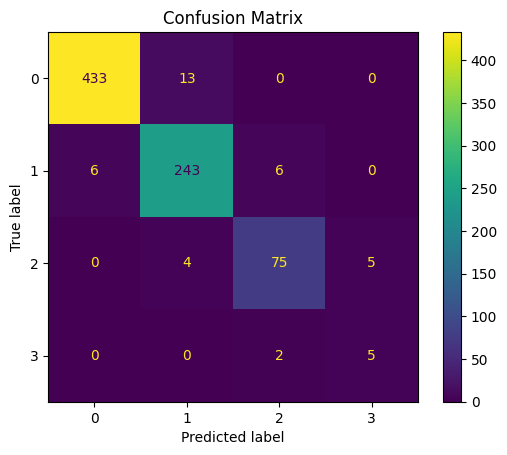

In [34]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [35]:
# Make predictions on the test set
y_test_pred = best_pipeline.predict(X_test)

# Save the predictions to a file
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})
#output_df.to_csv('submission.csv', index=False)

In [36]:
output_df

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1
